In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, GlobalAveragePooling2D
import os
import cv2
import pickle
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Model


from imblearn.under_sampling import RandomUnderSampler
from keras.utils.np_utils import to_categorical
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

%load_ext tensorboard

In [2]:
dataPath = "../../data/OCT/OCT2017/"

In [3]:
labels_available = os.listdir(os.path.join(dataPath, "train"))
print("Total Number of Classes Detected :",len(labels_available))

labels_list = ['NORMAL',"CNV","DME","DRUSEN"]

Total Number of Classes Detected : 4


In [4]:
images=[]
y_trn=[]
for x in labels_list:
    xPath = os.path.join(dataPath, "train", x)
    myPicList = os.listdir(xPath)
    for y in myPicList:
        images.append(cv2.imread(os.path.join(xPath, y)))
        y_trn.append(labels_list.index(x))
    print(x ,end=" ")

y_train = to_categorical(y_trn,len(labels_list))

NORMAL CNV DME DRUSEN 

In [5]:
x_val=[]
y_val=[]
for x in labels_list:
    xPath = os.path.join(dataPath, "val", x)
    myPicList = os.listdir(xPath)
    for y in myPicList:
        x_val.append(cv2.imread(os.path.join(xPath, y)))
        y_val.append(labels_list.index(x))
    print(x ,end=" ")

y_validation = to_categorical(y_val,len(labels_list))

NORMAL CNV DME DRUSEN 

In [6]:
x_tst=[]
y_tst=[]
for x in labels_list:
    xPath = os.path.join(dataPath, "test", x)
    myPicList = os.listdir(xPath)
    for y in myPicList:
        x_tst.append(cv2.imread(os.path.join(xPath, y)))
        y_tst.append(labels_list.index(x))
    print(x ,end=" ")

NORMAL CNV DME DRUSEN 

In [7]:
def resizeIm(im, size):
    if im.shape[2] == 1:
        im = cv2.cvtColor(im,cv2.COLOR_GRAY2RGB)
    return cv2.resize(im, size)

def resizeIms(x, size):
    return np.array(list(map(lambda im: resizeIm(im, size), x)))

In [8]:
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self,fraction, model):
        super(CustomCallback,self).__init__()
        self.fraction = fraction
        self.train_a = [];
        self.val_a =[];
        self.logPath = os.path.join(model, "log.txt")

        if not os.path.isdir(model):
            os.mkdir(model)

        with open(self.logPath,'w') as f:
            f.write('Starting of logging..\n')

        self.fig = plt.figure(figsize=(4,3))
        self.ax = plt.subplot(1,1,1)
        plt.ion()

    def on_train_begin(self,logs=None):
        self.fig.show()
        self.fig.canvas.draw()

    def on_train_end(self,logs=None):
        with open(self.logPath,'a') as f:
              f.write('End of logging..\n')
    
    def on_epoch_begin(self,epoch,logs=None):
        lr= tf.keras.backend.get_value(self.model.optimizer.lr)
        lr *= self.fraction
        tf.keras.backend.set_value(self.model.optimizer.lr,lr)
        with open(self.logPath,'a') as f:
            f.write('At epoch {:02d}, learning rate changed to {:.4f}\n'.format(epoch,lr))
    
    def on_epoch_end(self,epoch,logs=None):
        val_acc = logs.get('val_accuracy')
        train_acc = logs.get('accuracy')
        self.train_a.append(train_acc)
        self.val_a.append(val_acc)
        with open(self.logPath,'a') as f:
            f.write('At epoch {:02d}, training accuracy: {:.3f}, validation accuracy: {:.3f}\n'.format(epoch,train_acc,val_acc))
        self.ax.clear()
        self.ax.plot(range(1+epoch),self.train_a,label="Training")
        self.ax.plot(range(1+epoch),self.val_a,label="Validation")
        self.ax.set_xlabel('Epochs')
        self.ax.set_ylabel('Accuracy')
        self.ax.legend()
        self.fig.canvas.draw()
        self.fig.show()

## Load models

In [9]:
# xception base model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input, decode_predictions
xceptionNetModel = Xception(weights='imagenet')

# opticnet base model
opticNetModel = tf.keras.models.load_model('../Optic_net-4_classes-Kermany2018.hdf5')

# resnet base model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

resNetModel = ResNet50(weights='imagenet')

In [13]:
def emptyModelGenerator(model, newWeights=False):
    model = model.lower()
    if model == "resnet":
        x = resNetModel.output
        predictions = Dense(len(labels_list), activation='softmax')(x)
        newModel = Model(inputs=resNetModel.input, outputs=predictions)
        size = (224, 224)
    elif model == "xception":
        x = xceptionNetModel.output
        predictions = Dense(len(labels_list), activation='softmax')(x)
        newModel = Model(inputs=xceptionNetModel.input, outputs=predictions)
        size = (299, 299)
    elif model == "opticnet":
        newModel = tf.keras.models.load_model('../Optic_net-4_classes-Kermany2018.hdf5')
        size = (224, 224)
    if newWeights:
        newModel = tf.keras.models.clone_model(newModel)
    return newModel, size


def testPredict(model, size, name=None):
    X_test = resizeIms(x_tst, size)
    X_test = np.array(X_test)
    Y_test = np.array(y_tst)
    
    prediction = model.predict(X_test)
    preds = np.argmax(prediction, axis=1)
    acc = sum(preds == Y_test) / len(Y_test)
    print(f'Test acc for {name if name else "model"}: {acc:.6f}')
    

def computeConfussionMatrix(predictions, labels):
    num_labels = len(labels_list)
    cMatrix = np.zeros(shape=(num_labels, num_labels))
    for i in len(predictions):
        p = int(predictions[i])
        t = int(predictions[i])
        cMatrix[t, p] += 1
    print(cMatrix)
    ax = sns.heatmap(cMatrix, cmap="Blues", annot=True, fmt="d", xticklabels=labels_list, yticklabels=labels_list)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title("Confusion matrix")
    plt.show();
    return cMatrix
    


In [14]:
optim = Adam(learning_rate=0.001)
epochs = 30
batch_size = 50

Labels fraction: [0.10115903 0.10044349 0.09834332 0.09668059]
Training xception for 0.1% of train size (aka 8348 images)...


<ipython-input-8-797fd00c81c1>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 1/30
167/167 [==============================] - 138s 795ms/step - loss: 1.3058 - accuracy: 0.6015 - val_loss: 1.3936 - val_accuracy: 0.2500


<ipython-input-8-797fd00c81c1>:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 2/30
167/167 [==============================] - 131s 783ms/step - loss: 1.1257 - accuracy: 0.7316 - val_loss: 1.4950 - val_accuracy: 0.2500
Epoch 3/30
167/167 [==============================] - 131s 784ms/step - loss: 1.0329 - accuracy: 0.7211 - val_loss: 1.2975 - val_accuracy: 0.5000
Epoch 4/30
167/167 [==============================] - 130s 780ms/step - loss: 0.9373 - accuracy: 0.7610 - val_loss: 1.5763 - val_accuracy: 0.2500
Epoch 5/30
167/167 [==============================] - 131s 783ms/step - loss: 0.8698 - accuracy: 0.7826 - val_loss: 1.3784 - val_accuracy: 0.4688
Epoch 6/30
167/167 [==============================] - 131s 782ms/step - loss: 0.7953 - accuracy: 0.8079 - val_loss: 1.0480 - val_accuracy: 0.6562
Epoch 7/30
167/167 [==============================] - 130s 780ms/step - loss: 0.7508 - accuracy: 0.8136 - val_loss: 1.1607 - val_accuracy: 0.6250
Epoch 8/30
167/167 [==============================] - 130s 781ms/step - loss: 0.7145 - accuracy: 0.8199 - val_loss: 0.8559 -

<ipython-input-8-797fd00c81c1>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 1/30
167/167 [==============================] - 46s 228ms/step - loss: 1.3317 - accuracy: 0.4314 - val_loss: 1.4293 - val_accuracy: 0.2500


<ipython-input-8-797fd00c81c1>:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 2/30
167/167 [==============================] - 33s 199ms/step - loss: 1.2555 - accuracy: 0.4511 - val_loss: 1.4772 - val_accuracy: 0.2500
Epoch 3/30
167/167 [==============================] - 33s 200ms/step - loss: 1.2313 - accuracy: 0.4519 - val_loss: 1.5096 - val_accuracy: 0.2500
Epoch 4/30
167/167 [==============================] - 33s 200ms/step - loss: 1.2294 - accuracy: 0.4504 - val_loss: 1.5296 - val_accuracy: 0.2500
Epoch 5/30
167/167 [==============================] - 33s 200ms/step - loss: 1.2248 - accuracy: 0.4480 - val_loss: 1.5420 - val_accuracy: 0.2500
Epoch 6/30
167/167 [==============================] - 33s 200ms/step - loss: 1.2235 - accuracy: 0.4504 - val_loss: 1.5504 - val_accuracy: 0.2500
Epoch 7/30
167/167 [==============================] - 33s 200ms/step - loss: 1.2313 - accuracy: 0.4399 - val_loss: 1.5551 - val_accuracy: 0.2500
Epoch 8/30
167/167 [==============================] - 33s 200ms/step - loss: 1.2248 - accuracy: 0.4448 - val_loss: 1.5590 - val_ac

<ipython-input-8-797fd00c81c1>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 1/30
167/167 [==============================] - 217s 1s/step - loss: 7.5634 - accuracy: 0.3663 - val_loss: 1.5677 - val_accuracy: 0.4062


<ipython-input-8-797fd00c81c1>:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 2/30
167/167 [==============================] - 197s 1s/step - loss: 0.9020 - accuracy: 0.6882 - val_loss: 1.2139 - val_accuracy: 0.4062
Epoch 3/30
167/167 [==============================] - 198s 1s/step - loss: 0.6504 - accuracy: 0.7756 - val_loss: 0.8401 - val_accuracy: 0.6562
Epoch 4/30
167/167 [==============================] - 196s 1s/step - loss: 0.5107 - accuracy: 0.8213 - val_loss: 1.3011 - val_accuracy: 0.6250
Epoch 5/30
167/167 [==============================] - 196s 1s/step - loss: 0.4204 - accuracy: 0.8569 - val_loss: 0.5118 - val_accuracy: 0.8125
Epoch 6/30
167/167 [==============================] - 196s 1s/step - loss: 0.3732 - accuracy: 0.8703 - val_loss: 0.5874 - val_accuracy: 0.7812
Epoch 7/30
167/167 [==============================] - 196s 1s/step - loss: 0.3094 - accuracy: 0.8890 - val_loss: 0.3957 - val_accuracy: 0.8750
Epoch 8/30
167/167 [==============================] - 197s 1s/step - loss: 0.2507 - accuracy: 0.9109 - val_loss: 0.2662 - val_accuracy: 0.9375

<ipython-input-8-797fd00c81c1>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 1/30
418/418 [==============================] - 332s 781ms/step - loss: 1.2399 - accuracy: 0.6732 - val_loss: 1.3215 - val_accuracy: 0.5000


<ipython-input-8-797fd00c81c1>:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 2/30
418/418 [==============================] - 322s 771ms/step - loss: 0.9766 - accuracy: 0.7257 - val_loss: 1.3588 - val_accuracy: 0.4688
Epoch 3/30
418/418 [==============================] - 323s 772ms/step - loss: 0.8393 - accuracy: 0.7625 - val_loss: 1.0311 - val_accuracy: 0.7188
Epoch 4/30
418/418 [==============================] - 322s 771ms/step - loss: 0.7133 - accuracy: 0.8060 - val_loss: 1.1681 - val_accuracy: 0.5625
Epoch 5/30
418/418 [==============================] - 322s 771ms/step - loss: 0.6205 - accuracy: 0.8319 - val_loss: 0.8567 - val_accuracy: 0.6562
Epoch 6/30
418/418 [==============================] - 322s 771ms/step - loss: 0.5263 - accuracy: 0.8550 - val_loss: 0.5990 - val_accuracy: 0.9375
Epoch 7/30
418/418 [==============================] - 322s 770ms/step - loss: 0.4506 - accuracy: 0.8961 - val_loss: 0.7102 - val_accuracy: 0.8750
Epoch 8/30
418/418 [==============================] - 322s 771ms/step - loss: 0.3923 - accuracy: 0.9120 - val_loss: 0.3325 -

<ipython-input-8-797fd00c81c1>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 1/30
418/418 [==============================] - 96s 211ms/step - loss: 1.2870 - accuracy: 0.4785 - val_loss: 1.3572 - val_accuracy: 0.5000


<ipython-input-8-797fd00c81c1>:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 2/30
418/418 [==============================] - 84s 200ms/step - loss: 1.0239 - accuracy: 0.7144 - val_loss: 1.6686 - val_accuracy: 0.2500
Epoch 3/30
418/418 [==============================] - 84s 201ms/step - loss: 0.8898 - accuracy: 0.7240 - val_loss: 1.2899 - val_accuracy: 0.4375
Epoch 4/30
418/418 [==============================] - 84s 200ms/step - loss: 0.7923 - accuracy: 0.7525 - val_loss: 1.3384 - val_accuracy: 0.5938
Epoch 5/30
418/418 [==============================] - 84s 200ms/step - loss: 0.7321 - accuracy: 0.7747 - val_loss: 1.2502 - val_accuracy: 0.6562
Epoch 6/30
418/418 [==============================] - 84s 200ms/step - loss: 0.6689 - accuracy: 0.8013 - val_loss: 1.1700 - val_accuracy: 0.6562
Epoch 7/30
418/418 [==============================] - 84s 200ms/step - loss: 0.6204 - accuracy: 0.8130 - val_loss: 0.9975 - val_accuracy: 0.6875
Epoch 8/30
418/418 [==============================] - 84s 200ms/step - loss: 0.5864 - accuracy: 0.8237 - val_loss: 0.8376 - val_ac

<ipython-input-8-797fd00c81c1>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 1/30
418/418 [==============================] - 509s 1s/step - loss: 3.5934 - accuracy: 0.5055 - val_loss: 1.6387 - val_accuracy: 0.5625


<ipython-input-8-797fd00c81c1>:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 2/30
418/418 [==============================] - 491s 1s/step - loss: 0.5355 - accuracy: 0.8111 - val_loss: 0.4799 - val_accuracy: 0.8750
Epoch 3/30
418/418 [==============================] - 492s 1s/step - loss: 0.3091 - accuracy: 0.8923 - val_loss: 1.3760 - val_accuracy: 0.5625
Epoch 4/30
418/418 [==============================] - 491s 1s/step - loss: 0.2422 - accuracy: 0.9178 - val_loss: 1.6344 - val_accuracy: 0.2500
Epoch 5/30
418/418 [==============================] - 492s 1s/step - loss: 0.2197 - accuracy: 0.9262 - val_loss: 0.1359 - val_accuracy: 0.9375
Epoch 6/30
418/418 [==============================] - 491s 1s/step - loss: 0.1914 - accuracy: 0.9346 - val_loss: 0.0765 - val_accuracy: 0.9688
Epoch 7/30
418/418 [==============================] - 489s 1s/step - loss: 0.1775 - accuracy: 0.9428 - val_loss: 0.3350 - val_accuracy: 0.8438
Epoch 8/30
418/418 [==============================] - 493s 1s/step - loss: 0.1531 - accuracy: 0.9499 - val_loss: 0.2307 - val_accuracy: 0.9062

<ipython-input-8-797fd00c81c1>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 1/30
668/668 [==============================] - 527s 782ms/step - loss: 1.1925 - accuracy: 0.6795 - val_loss: 1.1758 - val_accuracy: 0.5000


<ipython-input-8-797fd00c81c1>:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 2/30
668/668 [==============================] - 518s 776ms/step - loss: 0.8286 - accuracy: 0.7686 - val_loss: 0.9590 - val_accuracy: 0.6875
Epoch 3/30
668/668 [==============================] - 519s 777ms/step - loss: 0.6537 - accuracy: 0.8282 - val_loss: 1.2281 - val_accuracy: 0.5312
Epoch 4/30
668/668 [==============================] - 519s 777ms/step - loss: 0.5453 - accuracy: 0.8412 - val_loss: 0.6176 - val_accuracy: 0.7500
Epoch 5/30
668/668 [==============================] - 519s 776ms/step - loss: 0.4765 - accuracy: 0.8505 - val_loss: 0.5151 - val_accuracy: 0.7500
Epoch 6/30
668/668 [==============================] - 518s 775ms/step - loss: 0.4174 - accuracy: 0.8608 - val_loss: 0.4952 - val_accuracy: 0.7500
Epoch 7/30
668/668 [==============================] - 518s 776ms/step - loss: 0.3408 - accuracy: 0.9296 - val_loss: 0.2771 - val_accuracy: 1.0000
Epoch 8/30
668/668 [==============================] - 519s 776ms/step - loss: 0.2767 - accuracy: 0.9443 - val_loss: 0.2596 -

<ipython-input-8-797fd00c81c1>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 1/30
668/668 [==============================] - 146s 207ms/step - loss: 1.2905 - accuracy: 0.4426 - val_loss: 1.5412 - val_accuracy: 0.2500


<ipython-input-8-797fd00c81c1>:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 2/30
668/668 [==============================] - 134s 200ms/step - loss: 1.2284 - accuracy: 0.4503 - val_loss: 1.5605 - val_accuracy: 0.2500
Epoch 3/30
668/668 [==============================] - 134s 200ms/step - loss: 1.2243 - accuracy: 0.4509 - val_loss: 1.5576 - val_accuracy: 0.2500
Epoch 4/30
668/668 [==============================] - 134s 200ms/step - loss: 1.2283 - accuracy: 0.4455 - val_loss: 1.5577 - val_accuracy: 0.2500
Epoch 5/30
668/668 [==============================] - 134s 200ms/step - loss: 1.2273 - accuracy: 0.4494 - val_loss: 1.5594 - val_accuracy: 0.2500
Epoch 6/30
668/668 [==============================] - 134s 200ms/step - loss: 1.2319 - accuracy: 0.4447 - val_loss: 1.5642 - val_accuracy: 0.2500
Epoch 7/30
668/668 [==============================] - 134s 200ms/step - loss: 1.2267 - accuracy: 0.4504 - val_loss: 1.5604 - val_accuracy: 0.2500
Epoch 8/30
668/668 [==============================] - 134s 200ms/step - loss: 1.2316 - accuracy: 0.4454 - val_loss: 1.5620 -

<ipython-input-8-797fd00c81c1>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 1/30
668/668 [==============================] - 807s 1s/step - loss: 2.9172 - accuracy: 0.5744 - val_loss: 0.9390 - val_accuracy: 0.6250


<ipython-input-8-797fd00c81c1>:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 2/30
668/668 [==============================] - 785s 1s/step - loss: 0.4361 - accuracy: 0.8481 - val_loss: 0.9199 - val_accuracy: 0.5938
Epoch 3/30
668/668 [==============================] - 788s 1s/step - loss: 0.2659 - accuracy: 0.9125 - val_loss: 0.5032 - val_accuracy: 0.8438
Epoch 4/30
668/668 [==============================] - 785s 1s/step - loss: 0.2175 - accuracy: 0.9267 - val_loss: 0.2832 - val_accuracy: 0.8750
Epoch 5/30
668/668 [==============================] - 788s 1s/step - loss: 0.1864 - accuracy: 0.9366 - val_loss: 0.1249 - val_accuracy: 0.9062
Epoch 6/30
668/668 [==============================] - 785s 1s/step - loss: 0.1668 - accuracy: 0.9435 - val_loss: 0.1521 - val_accuracy: 0.9375
Epoch 7/30
668/668 [==============================] - 783s 1s/step - loss: 0.1417 - accuracy: 0.9535 - val_loss: 0.0448 - val_accuracy: 1.0000
Epoch 8/30
668/668 [==============================] - 785s 1s/step - loss: 0.1246 - accuracy: 0.9581 - val_loss: 0.2087 - val_accuracy: 0.9375

<ipython-input-8-797fd00c81c1>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 1/30
835/835 [==============================] - 660s 784ms/step - loss: 1.1644 - accuracy: 0.6899 - val_loss: 1.1734 - val_accuracy: 0.5938


<ipython-input-8-797fd00c81c1>:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 2/30
835/835 [==============================] - 650s 778ms/step - loss: 0.7749 - accuracy: 0.7911 - val_loss: 0.7151 - val_accuracy: 0.7500
Epoch 3/30
835/835 [==============================] - 650s 778ms/step - loss: 0.5835 - accuracy: 0.8319 - val_loss: 0.6397 - val_accuracy: 0.7500
Epoch 4/30
835/835 [==============================] - 652s 781ms/step - loss: 0.4635 - accuracy: 0.8504 - val_loss: 0.6035 - val_accuracy: 0.7188
Epoch 5/30
835/835 [==============================] - 651s 780ms/step - loss: 0.3710 - accuracy: 0.9082 - val_loss: 0.2088 - val_accuracy: 1.0000
Epoch 6/30
835/835 [==============================] - 652s 781ms/step - loss: 0.2708 - accuracy: 0.9402 - val_loss: 0.2040 - val_accuracy: 0.9375
Epoch 7/30
835/835 [==============================] - 652s 781ms/step - loss: 0.2139 - accuracy: 0.9514 - val_loss: 0.1100 - val_accuracy: 1.0000
Epoch 8/30
835/835 [==============================] - 652s 781ms/step - loss: 0.1898 - accuracy: 0.9555 - val_loss: 0.0934 -

<ipython-input-8-797fd00c81c1>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 1/30
835/835 [==============================] - 178s 206ms/step - loss: 1.2853 - accuracy: 0.4401 - val_loss: 1.5586 - val_accuracy: 0.2500


<ipython-input-8-797fd00c81c1>:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 2/30
835/835 [==============================] - 168s 202ms/step - loss: 1.2293 - accuracy: 0.4486 - val_loss: 1.5581 - val_accuracy: 0.2500
Epoch 3/30
835/835 [==============================] - 168s 201ms/step - loss: 1.2280 - accuracy: 0.4494 - val_loss: 1.5601 - val_accuracy: 0.2500
Epoch 4/30
835/835 [==============================] - 167s 201ms/step - loss: 1.2307 - accuracy: 0.4469 - val_loss: 1.5601 - val_accuracy: 0.2500
Epoch 5/30
835/835 [==============================] - 167s 201ms/step - loss: 1.2340 - accuracy: 0.4428 - val_loss: 1.5622 - val_accuracy: 0.2500
Epoch 6/30
835/835 [==============================] - 168s 201ms/step - loss: 1.2279 - accuracy: 0.4478 - val_loss: 1.5623 - val_accuracy: 0.2500
Epoch 7/30
835/835 [==============================] - 168s 201ms/step - loss: 1.2270 - accuracy: 0.4505 - val_loss: 1.5584 - val_accuracy: 0.2500
Epoch 8/30
835/835 [==============================] - 167s 200ms/step - loss: 1.2277 - accuracy: 0.4490 - val_loss: 1.5609 -

<ipython-input-8-797fd00c81c1>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 1/30
835/835 [==============================] - 1006s 1s/step - loss: 3.1048 - accuracy: 0.5683 - val_loss: 1.0122 - val_accuracy: 0.6875


<ipython-input-8-797fd00c81c1>:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 2/30
835/835 [==============================] - 984s 1s/step - loss: 0.3191 - accuracy: 0.8890 - val_loss: 1.3275 - val_accuracy: 0.7500
Epoch 3/30
835/835 [==============================] - 984s 1s/step - loss: 0.2332 - accuracy: 0.9236 - val_loss: 0.6221 - val_accuracy: 0.6875
Epoch 4/30
835/835 [==============================] - 987s 1s/step - loss: 0.2011 - accuracy: 0.9326 - val_loss: 0.2824 - val_accuracy: 0.8750
Epoch 5/30
835/835 [==============================] - 986s 1s/step - loss: 0.1806 - accuracy: 0.9393 - val_loss: 1.4678 - val_accuracy: 0.5000
Epoch 6/30
835/835 [==============================] - 984s 1s/step - loss: 0.1582 - accuracy: 0.9477 - val_loss: 0.6777 - val_accuracy: 0.8125
Epoch 7/30
835/835 [==============================] - 985s 1s/step - loss: 0.1386 - accuracy: 0.9536 - val_loss: 0.1201 - val_accuracy: 0.9375
Epoch 8/30
835/835 [==============================] - 980s 1s/step - loss: 0.1247 - accuracy: 0.9575 - val_loss: 0.2435 - val_accuracy: 0.9375

<ipython-input-8-797fd00c81c1>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 1/30
1002/1002 [==============================] - 789s 781ms/step - loss: 1.1432 - accuracy: 0.7007 - val_loss: 1.4959 - val_accuracy: 0.4062


<ipython-input-8-797fd00c81c1>:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 2/30
1002/1002 [==============================] - 779s 777ms/step - loss: 0.6968 - accuracy: 0.8151 - val_loss: 0.5245 - val_accuracy: 0.9375
Epoch 3/30
1002/1002 [==============================] - 779s 777ms/step - loss: 0.4442 - accuracy: 0.8984 - val_loss: 0.4160 - val_accuracy: 0.9062
Epoch 4/30
1002/1002 [==============================] - 781s 779ms/step - loss: 0.2978 - accuracy: 0.9322 - val_loss: 0.1383 - val_accuracy: 1.0000
Epoch 5/30
1002/1002 [==============================] - 779s 778ms/step - loss: 0.2282 - accuracy: 0.9455 - val_loss: 0.1049 - val_accuracy: 1.0000
Epoch 6/30
1002/1002 [==============================] - 778s 777ms/step - loss: 0.1855 - accuracy: 0.9538 - val_loss: 0.1122 - val_accuracy: 0.9688
Epoch 7/30
1002/1002 [==============================] - 779s 777ms/step - loss: 0.1594 - accuracy: 0.9596 - val_loss: 0.0953 - val_accuracy: 0.9688
Epoch 8/30
1002/1002 [==============================] - 780s 778ms/step - loss: 0.1357 - accuracy: 0.9632 - val_

<ipython-input-8-797fd00c81c1>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 1/30
1002/1002 [==============================] - 212s 205ms/step - loss: 1.2158 - accuracy: 0.5530 - val_loss: 1.3461 - val_accuracy: 0.5000


<ipython-input-8-797fd00c81c1>:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 2/30
1002/1002 [==============================] - 201s 201ms/step - loss: 0.8700 - accuracy: 0.7178 - val_loss: 1.3575 - val_accuracy: 0.5312
Epoch 3/30
1002/1002 [==============================] - 201s 200ms/step - loss: 0.7522 - accuracy: 0.7450 - val_loss: 1.0379 - val_accuracy: 0.5000
Epoch 4/30
1002/1002 [==============================] - 201s 200ms/step - loss: 0.6558 - accuracy: 0.7843 - val_loss: 2.0883 - val_accuracy: 0.2812
Epoch 5/30
1002/1002 [==============================] - 201s 200ms/step - loss: 0.5826 - accuracy: 0.8063 - val_loss: 0.7955 - val_accuracy: 0.7500
Epoch 6/30
1002/1002 [==============================] - 201s 200ms/step - loss: 0.5300 - accuracy: 0.8216 - val_loss: 1.0979 - val_accuracy: 0.5938
Epoch 7/30
1002/1002 [==============================] - 201s 200ms/step - loss: 0.4668 - accuracy: 0.8599 - val_loss: 0.4441 - val_accuracy: 0.9062
Epoch 8/30
1002/1002 [==============================] - 201s 200ms/step - loss: 0.3852 - accuracy: 0.8917 - val_

<ipython-input-8-797fd00c81c1>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 1/30
1002/1002 [==============================] - 1208s 1s/step - loss: 2.1560 - accuracy: 0.6427 - val_loss: 0.5819 - val_accuracy: 0.8125


<ipython-input-8-797fd00c81c1>:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 2/30
1002/1002 [==============================] - 1187s 1s/step - loss: 0.3059 - accuracy: 0.8975 - val_loss: 0.2991 - val_accuracy: 0.9062
Epoch 3/30
1002/1002 [==============================] - 1186s 1s/step - loss: 0.2212 - accuracy: 0.9265 - val_loss: 0.1361 - val_accuracy: 0.9688
Epoch 4/30
1002/1002 [==============================] - 1186s 1s/step - loss: 0.1883 - accuracy: 0.9364 - val_loss: 0.2730 - val_accuracy: 0.9062
Epoch 5/30
1002/1002 [==============================] - 1184s 1s/step - loss: 0.1707 - accuracy: 0.9437 - val_loss: 0.0284 - val_accuracy: 1.0000
Epoch 6/30
1002/1002 [==============================] - 1183s 1s/step - loss: 0.1480 - accuracy: 0.9507 - val_loss: 0.0788 - val_accuracy: 0.9688
Epoch 7/30
1002/1002 [==============================] - 1184s 1s/step - loss: 0.1288 - accuracy: 0.9553 - val_loss: 0.0768 - val_accuracy: 0.9688
Epoch 8/30
1002/1002 [==============================] - 1182s 1s/step - loss: 0.1146 - accuracy: 0.9612 - val_loss: 0.2378 -

<ipython-input-8-797fd00c81c1>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 1/30
1253/1253 [==============================] - 972s 772ms/step - loss: 1.1076 - accuracy: 0.7086 - val_loss: 0.9670 - val_accuracy: 0.6875


<ipython-input-8-797fd00c81c1>:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 2/30
1253/1253 [==============================] - 967s 772ms/step - loss: 0.6684 - accuracy: 0.8051 - val_loss: 0.5565 - val_accuracy: 0.9062
Epoch 3/30
1253/1253 [==============================] - 966s 771ms/step - loss: 0.4402 - accuracy: 0.8900 - val_loss: 0.2917 - val_accuracy: 0.9688
Epoch 4/30
1253/1253 [==============================] - 968s 773ms/step - loss: 0.2919 - accuracy: 0.9268 - val_loss: 0.1516 - val_accuracy: 0.9375
Epoch 5/30
1253/1253 [==============================] - 967s 772ms/step - loss: 0.2207 - accuracy: 0.9446 - val_loss: 0.1240 - val_accuracy: 0.9688
Epoch 6/30
1253/1253 [==============================] - 966s 771ms/step - loss: 0.1790 - accuracy: 0.9534 - val_loss: 0.0697 - val_accuracy: 1.0000
Epoch 7/30
1253/1253 [==============================] - 968s 772ms/step - loss: 0.1521 - accuracy: 0.9584 - val_loss: 0.0692 - val_accuracy: 0.9688
Epoch 8/30
1253/1253 [==============================] - 967s 772ms/step - loss: 0.1299 - accuracy: 0.9651 - val_

<ipython-input-8-797fd00c81c1>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 1/30
1253/1253 [==============================] - 260s 202ms/step - loss: 1.2701 - accuracy: 0.4418 - val_loss: 1.5566 - val_accuracy: 0.2500


<ipython-input-8-797fd00c81c1>:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 2/30
1253/1253 [==============================] - 251s 200ms/step - loss: 1.2310 - accuracy: 0.4486 - val_loss: 1.5595 - val_accuracy: 0.2500
Epoch 3/30
1253/1253 [==============================] - 250s 200ms/step - loss: 1.2262 - accuracy: 0.4486 - val_loss: 1.5576 - val_accuracy: 0.2500
Epoch 4/30
1253/1253 [==============================] - 251s 200ms/step - loss: 1.2305 - accuracy: 0.4452 - val_loss: 1.5639 - val_accuracy: 0.2500
Epoch 5/30
1253/1253 [==============================] - 250s 200ms/step - loss: 1.2306 - accuracy: 0.4467 - val_loss: 1.5571 - val_accuracy: 0.2500
Epoch 6/30
1253/1253 [==============================] - 251s 200ms/step - loss: 1.2292 - accuracy: 0.4490 - val_loss: 1.5585 - val_accuracy: 0.2500
Epoch 7/30
1253/1253 [==============================] - 250s 200ms/step - loss: 1.2281 - accuracy: 0.4464 - val_loss: 1.5592 - val_accuracy: 0.2500
Epoch 8/30
1253/1253 [==============================] - 251s 200ms/step - loss: 1.2271 - accuracy: 0.4496 - val_

<ipython-input-8-797fd00c81c1>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 1/30
1253/1253 [==============================] - 1499s 1s/step - loss: 2.1986 - accuracy: 0.6070 - val_loss: 0.8954 - val_accuracy: 0.6562


<ipython-input-8-797fd00c81c1>:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 2/30
1253/1253 [==============================] - 1480s 1s/step - loss: 0.2830 - accuracy: 0.9036 - val_loss: 0.7178 - val_accuracy: 0.7812
Epoch 3/30
1253/1253 [==============================] - 1476s 1s/step - loss: 0.2101 - accuracy: 0.9313 - val_loss: 0.4051 - val_accuracy: 0.8750
Epoch 4/30
1253/1253 [==============================] - 1478s 1s/step - loss: 0.1896 - accuracy: 0.9366 - val_loss: 0.4948 - val_accuracy: 0.7812
Epoch 5/30
1253/1253 [==============================] - 1480s 1s/step - loss: 0.1638 - accuracy: 0.9447 - val_loss: 0.1298 - val_accuracy: 0.9688
Epoch 6/30
1253/1253 [==============================] - 1476s 1s/step - loss: 0.1384 - accuracy: 0.9527 - val_loss: 0.1737 - val_accuracy: 0.9062
Epoch 7/30
1253/1253 [==============================] - 1485s 1s/step - loss: 0.1306 - accuracy: 0.9556 - val_loss: 0.0413 - val_accuracy: 1.0000
Epoch 8/30
1253/1253 [==============================] - 1481s 1s/step - loss: 0.1073 - accuracy: 0.9640 - val_loss: 0.0175 -

<ipython-input-8-797fd00c81c1>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 1/30
1503/1503 [==============================] - 1170s 775ms/step - loss: 1.0617 - accuracy: 0.7272 - val_loss: 0.9942 - val_accuracy: 0.6562


<ipython-input-8-797fd00c81c1>:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 2/30
1503/1503 [==============================] - 1162s 773ms/step - loss: 0.5807 - accuracy: 0.8437 - val_loss: 0.3374 - val_accuracy: 0.9375
Epoch 3/30
1503/1503 [==============================] - 1162s 773ms/step - loss: 0.3278 - accuracy: 0.9182 - val_loss: 0.4560 - val_accuracy: 0.8750
Epoch 4/30
1503/1503 [==============================] - 1164s 774ms/step - loss: 0.2439 - accuracy: 0.9363 - val_loss: 0.0891 - val_accuracy: 1.0000
Epoch 5/30
1503/1503 [==============================] - 1161s 772ms/step - loss: 0.1867 - accuracy: 0.9491 - val_loss: 0.0619 - val_accuracy: 1.0000
Epoch 6/30
1503/1503 [==============================] - 1163s 774ms/step - loss: 0.1556 - accuracy: 0.9570 - val_loss: 0.0453 - val_accuracy: 1.0000
Epoch 7/30
1503/1503 [==============================] - 1162s 773ms/step - loss: 0.1352 - accuracy: 0.9620 - val_loss: 0.0378 - val_accuracy: 1.0000
Epoch 8/30
1503/1503 [==============================] - 1162s 773ms/step - loss: 0.1135 - accuracy: 0.9680

<ipython-input-8-797fd00c81c1>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 1/30
1503/1503 [==============================] - 313s 203ms/step - loss: 1.1208 - accuracy: 0.6601 - val_loss: 1.5482 - val_accuracy: 0.3438


<ipython-input-8-797fd00c81c1>:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 2/30
1503/1503 [==============================] - 301s 200ms/step - loss: 0.8130 - accuracy: 0.7167 - val_loss: 0.8285 - val_accuracy: 0.6875
Epoch 3/30
1503/1503 [==============================] - 301s 200ms/step - loss: 0.6903 - accuracy: 0.7675 - val_loss: 1.0166 - val_accuracy: 0.5938
Epoch 4/30
1503/1503 [==============================] - 301s 200ms/step - loss: 0.5785 - accuracy: 0.8082 - val_loss: 1.0446 - val_accuracy: 0.5938
Epoch 5/30
1503/1503 [==============================] - 301s 200ms/step - loss: 0.4608 - accuracy: 0.8603 - val_loss: 0.7551 - val_accuracy: 0.7500
Epoch 6/30
1503/1503 [==============================] - 301s 200ms/step - loss: 0.3391 - accuracy: 0.9033 - val_loss: 0.1387 - val_accuracy: 1.0000
Epoch 7/30
1503/1503 [==============================] - 301s 200ms/step - loss: 0.2669 - accuracy: 0.9273 - val_loss: 0.0892 - val_accuracy: 1.0000
Epoch 8/30
1503/1503 [==============================] - 301s 200ms/step - loss: 0.2222 - accuracy: 0.9366 - val_

<ipython-input-8-797fd00c81c1>:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self.fig = plt.figure(figsize=(4,3))
<ipython-input-8-797fd00c81c1>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 1/30
1503/1503 [==============================] - 1795s 1s/step - loss: 1.9556 - accuracy: 0.6501 - val_loss: 0.3071 - val_accuracy: 0.9062


<ipython-input-8-797fd00c81c1>:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 2/30
1503/1503 [==============================] - 1783s 1s/step - loss: 0.2678 - accuracy: 0.9112 - val_loss: 0.3129 - val_accuracy: 0.8438
Epoch 3/30
1503/1503 [==============================] - 1783s 1s/step - loss: 0.2049 - accuracy: 0.9318 - val_loss: 0.0276 - val_accuracy: 1.0000
Epoch 4/30
1503/1503 [==============================] - 1783s 1s/step - loss: 0.1709 - accuracy: 0.9431 - val_loss: 0.2035 - val_accuracy: 0.8750
Epoch 5/30
1503/1503 [==============================] - 1783s 1s/step - loss: 0.1504 - accuracy: 0.9486 - val_loss: 0.0338 - val_accuracy: 1.0000
Epoch 6/30
1503/1503 [==============================] - 1783s 1s/step - loss: 0.1313 - accuracy: 0.9543 - val_loss: 0.0834 - val_accuracy: 0.9375
Epoch 7/30
1503/1503 [==============================] - 1783s 1s/step - loss: 0.1175 - accuracy: 0.9593 - val_loss: 0.0654 - val_accuracy: 1.0000
Epoch 8/30
1503/1503 [==============================] - 1783s 1s/step - loss: 0.0975 - accuracy: 0.9661 - val_loss: 0.0210 -

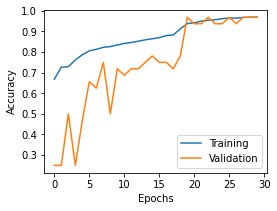

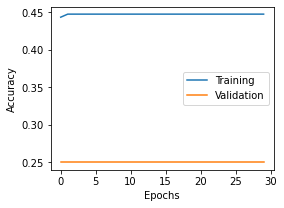

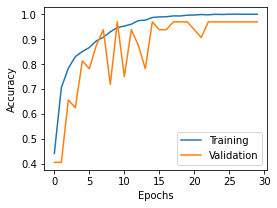

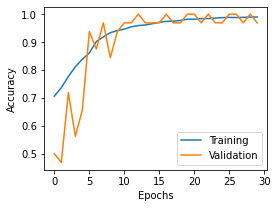

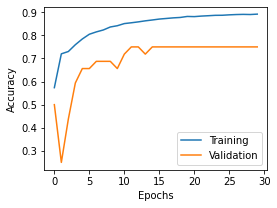

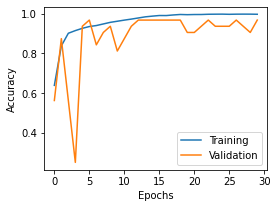

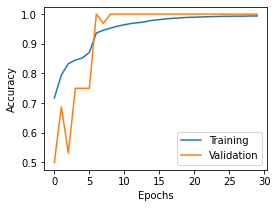

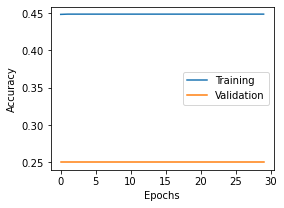

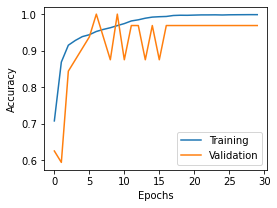

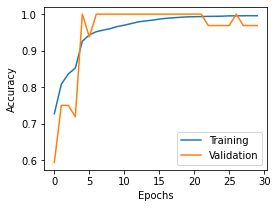

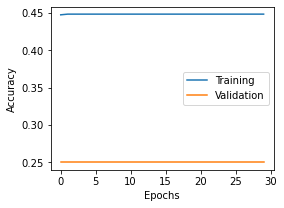

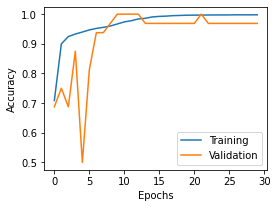

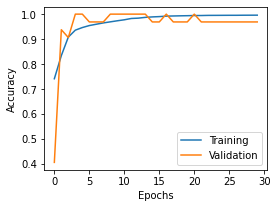

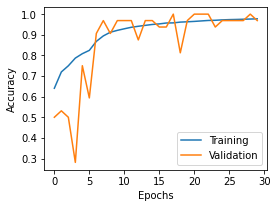

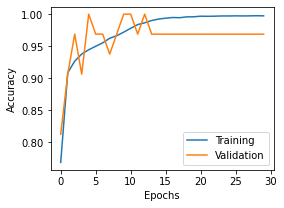

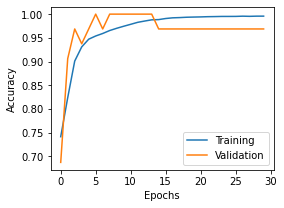

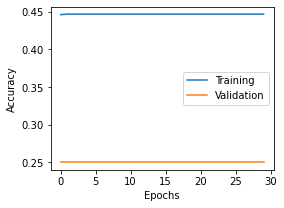

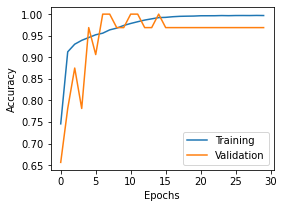

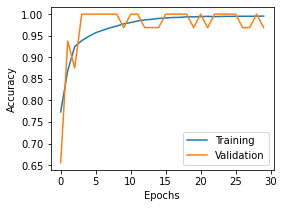

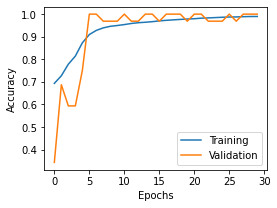

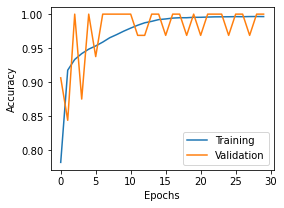

In [16]:
from sklearn.model_selection import train_test_split
import datetime

maxTrain = len(y_train)
#for p in [0.01, 0.025, 0.05, 0.075, 0.09]:
for p in [0.1, 0.25, 0.4, 0.5, 0.6, 0.75, 0.9]:
    #X_trn, X_tst, y_trn, y_tst
    X_t, _, y_t, _ = train_test_split(images, y_train, test_size=1-p, random_state=123)
    print(f"Labels fraction: {sum(y_t == 1) / sum(y_train == 1)}")
    for net in ["xception", "resnet", "opticnet"]:
        print(f"Training {net} for {p}% of train size (aka {len(X_t)} images)...")
        model, size = emptyModelGenerator(net, True) # new weights
        X_trn = resizeIms(X_t, size)
        X_val = resizeIms(x_val, size)
        log_dir = f"logs/{net}/fit/{p}trainSet_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
        optim = Adam(learning_rate=0.001)
        model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])
        hist = model.fit(X_trn, y_t, epochs=epochs, validation_data = (X_val, y_validation), batch_size=batch_size,
                    shuffle=True, max_queue_size=20,
                    use_multiprocessing=True, workers=5, 
                    callbacks=[CustomCallback(fraction=0.9, model=net), tensorboard_callback])
        model.save(f"../{net}/{net}_{epochs}epochs_{p*maxTrain} images")
        testPredict(model, size, name=net)
        del model
        del X_trn
        del X_val
        print("Done!\n" + '-'*50, end='\n\n')